# init

In [12]:
import sys 
sys.path.append('pyfiles/')
import classes_loop as cl
# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

# math stuff
import numpy as np
# visualization
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import distance
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline
# sliders
from ipywidgets import interactive

# for matrix import and display
import pandas as pd
from IPython.display import display_html 
import csv 

# to time things
import time

######## NOTE: from this point on, order is important. 
# it would be good to make the code more robust, but right
# now, there are ordered dependencies between functions.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## -------------------------------------------
## starting with two points, iteratively add new points between them to some tolerance, and the final one(s) is plotted as a medial axis point?


6 points
It took 0.000 sec to sort the complex 0
It took 0.270 sec to reduce the matrix 0
It took 0.000 sec to find bettis


It took 0.000 sec to sort the complex 1
It took 0.092 sec to reduce the matrix 1
It took 0.000 sec to find bettis




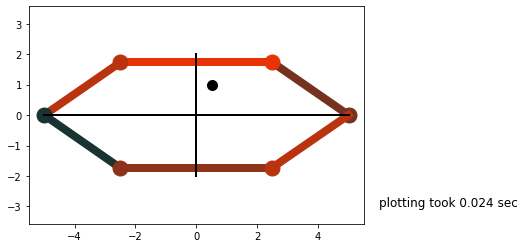

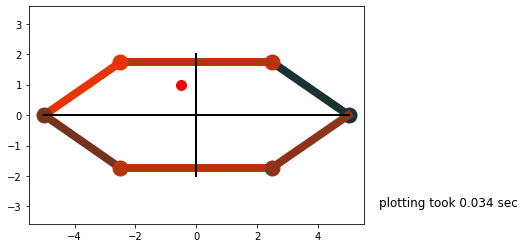

verts that killed the empy set: 
 [1, 2]
no type 3 knee for zero-homology (with epsilon nbhd of 1 )

edges that birthed one-homology:
 [3, 5]
type 3 knee between key points (0.5, 1) and (-0.5, 1) 
( with epsilon nbhd of 1 )


(False, True, 1)

In [44]:
point1 = (0.5, 1)
point2 = (-0.5, 1)

# num pts in sampling
n = 6
print(n, "points")
# init
vin = cl.vineyard()
# re init these just to make sure we can run this multiple times
vin.pointset = np.empty(2)
vin.complexlist = []
vin.matrixlist = []
vin.keypointlist = []

# add complexes
vin.add_complex(cl.ellipse_example(numpts = n, display = False), 
                point1, show_details = False, timethings = True)
vin.add_complex(cl.ellipse_example(numpts = n, display = False), 
                point2, show_details = False, timethings = True)
# plot
vin.complexlist[0].plot(extras = False, label_edges = False, 
                        label_verts = False, sp_pt_color = 'black', timethings = True)
vin.complexlist[1].plot(extras = False, 
                        label_edges = False, label_verts = False, timethings = True)

# the ints we input here are the complexes in order in vin, in the list complexlist
# returns: is_emptyset_knee, is_zero_knee, epsilon
vin.is_knee(0,1, eps = 1)

In [ ]:
if timethings:
      start_time = time.perf_counter() 
    # do things
    
if timethings:
    print(f"It took {time.perf_counter() - start_time :.3f} sec to sort the complex {len(self.complexlist)}")

## -----------------------------------
# ask herbert
- initial placement of grid pts (maxes and mins): what if we accidentally land exactly on the medial axis? should we do anything to try to avoid this? 
- how to pick epsilon? 

- epsilon -- we can also minimize it, right? this is equivalent to having just one interchange?
- another issue: let's say we have two points between which there is a knee, but we have sampled badly, and it happens that we should cross multiple critical areas. Then, the bisection method of halving the distance iteratively until we reach a suitable stopping place doesn't really work, because we now need to add in another point and do paralell bisection or something. How do we structure all of this so that we don't lose track of where to go?

## check 0 death / 1 birth switch

- if the simplex s in vin.matrixlist[0] that killed the empty set is much different than the one that killed the empty set in vin.matrixlist[1], then there is a dim 0 Type 3 Knee 
- this is easier to check than the next dimension of knee, because there's guaranteed to always be a simplex that kills the empty set if the complex isn't empty

# next: 
- pretty pictures. would be nice to visualize birth/death
- animations?! showing growth of complext for one point, and also for moving point around
- maths stuff: be able to tell if it's a type 3 knee
- make things faster: sparse matrix
- don't store things in duplicates
- later: refinement

# ToDo: 
- would be cool: replot the graph, but labeling mothers and murderers
- also cool: make graph into an animation that shows whole process
- separate voroni MA from example and add it as a graph option
- be able to tell if multiple interchanges happened
- if so, be able to find new special point and recompute things
- be able to tell if interchange was type changing (maybe should think about this first, because if multiple non type changing interchanges happen, maybe we don't actually care about them, and don't need to move special point)

-----

- to sell the work better: start writing down all the problems we encountered to justify why we do things this way (try to remember why phat didn't work etc) 

# Triangles will cause issues: 
- currently, knee-finding relies on only having verts and edges

- in sublime, alt shift arrows to have cursors appear all the places
- ctrl shift arrows switchy switch
- ctrl shift p to find the things